In [28]:
import tomotopy as tp
import os
import os.path
import utils
import prepocessing as pp
import text_processing as _tp
import random
import numpy as np
import sklearn
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import fs_n_training as ft

Initialise sLDA model,
`tw`: term weighting scheme
`k`: the number of topics
`vars`: response value type, `l` means linear

In [29]:
k_topic = 5
mdl = tp.SLDAModel(tw=tp.TermWeight.IDF,k=k_topic,vars='l')

Loading local dataset

In [30]:
docs_list = []

for i in range(len(pp.topic_label_map)):
        topic_path = os.path.join(pp.LOCAL_DIR, pp.topic_label_map[i][0])
        for doc_name in os.listdir(topic_path):
            doc_path = os.path.join(topic_path, doc_name)
            if os.path.isfile(doc_path):
                lines_set = utils.load_local_dataset(doc_path)
                doc_token_list = []
                for line in lines_set:
                    doc_token_list.extend(_tp.get_list_filtered_tokens(line))
            docs_list.append((doc_token_list,pp.topic_label_map[i][1]))

Splitting into train set and test set

In [31]:
random.shuffle(docs_list)

ratio = int(len(docs_list)*0.9)
train_docs_list = docs_list[:ratio]
test_docs_list = docs_list[ratio+1:len(docs_list)]

sLDA model training

In [32]:
for doc in train_docs_list:
    mdl.add_doc(doc[0],[doc[1]])
for i in range(0, len(mdl.docs), k_topic):
    mdl.train(5)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

likelihood: -30.841134092749822
Iteration: 50	Log-likelihood: -30.80859746287805
Iteration: 55	Log-likelihood: -30.774295400981696
Iteration: 60	Log-likelihood: -30.746457571310266
Iteration: 65	Log-likelihood: -30.718132987476608
Iteration: 70	Log-likelihood: -30.692550933205606
Iteration: 75	Log-likelihood: -30.671567348190518
Iteration: 80	Log-likelihood: -30.64731038849102
Iteration: 85	Log-likelihood: -30.62349268403573
Iteration: 90	Log-likelihood: -30.601161602384675
Iteration: 95	Log-likelihood: -30.579576020898156
Iteration: 100	Log-likelihood: -30.55357357200425
Iteration: 105	Log-likelihood: -30.537073005198348
Iteration: 110	Log-likelihood: -30.513475058186195
Iteration: 115	Log-likelihood: -30.497742177697948
Iteration: 120	Log-likelihood: -30.47962595284869
Iteration: 125	Log-likelihood: -30.464098050212286
Iteration: 130	Log-likelihood: -30.450948730589182
Iteration: 135	Log-likelihood: -30.42961479717788
Iteration: 140	Log-likelihood: -30.411955153193386
Iteration: 145	

Summary of sLDA model

In [33]:
for k in range(mdl.k):
    print('Top 5 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=k_topic))

mdl.summary()

Top 5 words of topic #0
[('mobile', 0.004896841011941433), ('phone', 0.004538826644420624), ('technology', 0.003899384755641222), ('service', 0.0033212609123438597), ('people', 0.0031715796794742346)]
Top 5 words of topic #1
[('mr', 0.004985431674867868), ('labour', 0.003475212724879384), ('party', 0.003310658736154437), ('election', 0.0030680166091769934), ('government', 0.003026972059160471)]
Top 5 words of topic #2
[('film', 0.008234648033976555), ('award', 0.004474798683077097), ('music', 0.0042810626327991486), ('best', 0.003929192665964365), ('show', 0.003282395889982581)]
Top 5 words of topic #3
[('i', 0.00624126149341464), ('england', 0.0033557170536369085), ('game', 0.0032787530217319727), ('club', 0.002989927539601922), ('ireland', 0.0027266512624919415)]
Top 5 words of topic #4
[('%', 0.0064511895179748535), ('$', 0.005370171274989843), ('bank', 0.0038248361088335514), ('us', 0.0037665232084691525), ('china', 0.0035426823887974024)]
<Basic Info>
| SLDAModel (current version:

Get topic distribution of each document

In [34]:
train_dist = []
for doc in mdl.docs:
    train_dist.append((doc.get_topic_dist(),doc.vars[0]))
    
test_dist = []

for doc in test_docs_list:
  mdl_doc = mdl.make_doc(doc[0],[doc[1]])
  test_dist.append(
      ((mdl.infer(mdl_doc)),doc[1]))

Vectorising topic distributions

In [35]:
train_dist_X = []
train_dist_y = []
test_dist_X =[]
test_dist_y=[]

for t in train_dist:
    train_dist_X.append(t[0])
    train_dist_y.append(t[1])
    
for t in test_dist:
    test_dist_X.append(t[0][0])
    test_dist_y.append(t[1])

Classifier training using linear SVC

In [36]:
svm_clf = Pipeline([
                ("std_scaler", StandardScaler()),
                ("svm_clf",SVC(kernel='linear',gamma='auto'))])
svm_clf.fit(train_dist_X,train_dist_y)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('svm_clf', SVC(gamma='auto', kernel='linear'))])

In [37]:
y_pred = svm_clf.predict(test_dist_X)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        40
           1       1.00      0.88      0.94        42
           2       0.91      0.93      0.92        42
           3       0.98      1.00      0.99        57
           4       0.87      0.95      0.91        41

    accuracy                           0.94       222
   macro avg       0.94      0.93      0.93       222
weighted avg       0.94      0.94      0.94       222



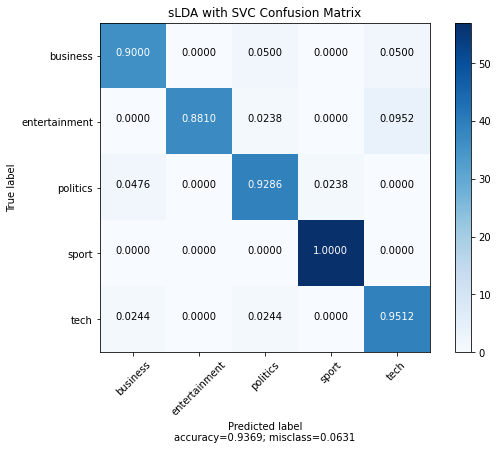

In [38]:
print(classification_report(test_dist_y,y_pred))
cm = confusion_matrix(test_dist_y,y_pred,labels=pp.topic_label_list)
ft.plot_confusion_matrix(cm,pp.topic_list,title="sLDA with SVC Confusion Matrix")

Predicting on up-to-date documents 

In [39]:
X_utd_docs = []
y = []
X_utd_vecs = []
utd_path = './unseen_dat/'
for doc_name in os.listdir(utd_path):
                doc_path = os.path.join(utd_path, doc_name)
                if os.path.isfile(doc_path):
                    lines_set = utils.load_local_dataset(doc_path)
                    token_list = []
                    for line in lines_set:
                        token_list.extend(_tp.get_list_filtered_tokens(line))
                    response = int(doc_name.split('_')[0])
                    X_utd_vecs.append(mdl.infer(
                        mdl.make_doc(token_list,[response])
                        )[0])
                    y.append(response)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         4
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         4
           4       1.00      0.50      0.67         4

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.89        20
weighted avg       0.92      0.90      0.89        20



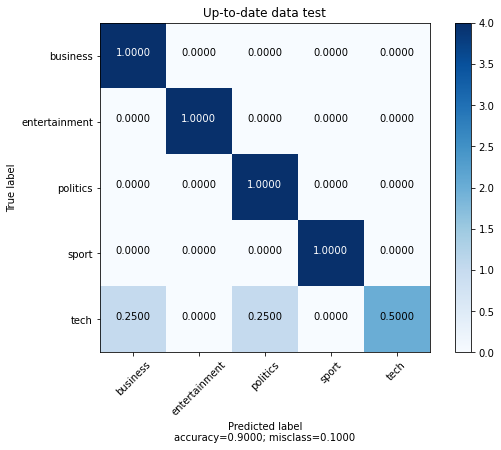

In [40]:
y_pred_utd = svm_clf.predict(X_utd_vecs)
print(classification_report(y,y_pred_utd))
cm_utd = confusion_matrix(y,y_pred_utd,labels=pp.topic_label_list)
ft.plot_confusion_matrix(cm_utd,pp.topic_list,title="Up-to-date data test")